In [1]:
from keras.layers import LSTM, Dense, Dropout
from keras.models import Model, Sequential, load_model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pylab import rcParams
from sklearn.preprocessing import MinMaxScaler

""" !wget command for running shell commands on notebooks """
!wget --no-check-certificate \
    https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/03/NSE-TATAGLOBAL11.csv \
    -O /tmp/NSE-TATAGLOBAL11.csv
  
rcParams["figure.figsize"] = (20, 10)

scaler = MinMaxScaler(feature_range=(0, 1))

df = pd.read_csv("/tmp/NSE-TATAGLOBAL11.csv")

df.head()
#printing the heads for the csv file.


Using TensorFlow backend.


--2019-07-04 11:04:51--  https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/03/NSE-TATAGLOBAL11.csv
Resolving s3-ap-south-1.amazonaws.com (s3-ap-south-1.amazonaws.com)... 52.219.64.66
Connecting to s3-ap-south-1.amazonaws.com (s3-ap-south-1.amazonaws.com)|52.219.64.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75099 (73K) [text/csv]
Saving to: ‘/tmp/NSE-TATAGLOBAL11.csv’

/tmp/NSE-TATAGLOBAL 100%[===================>]  73.34K   150KB/s    in 0.5s    

2019-07-04 11:04:52 (150 KB/s) - ‘/tmp/NSE-TATAGLOBAL11.csv’ saved [75099/75099]



,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


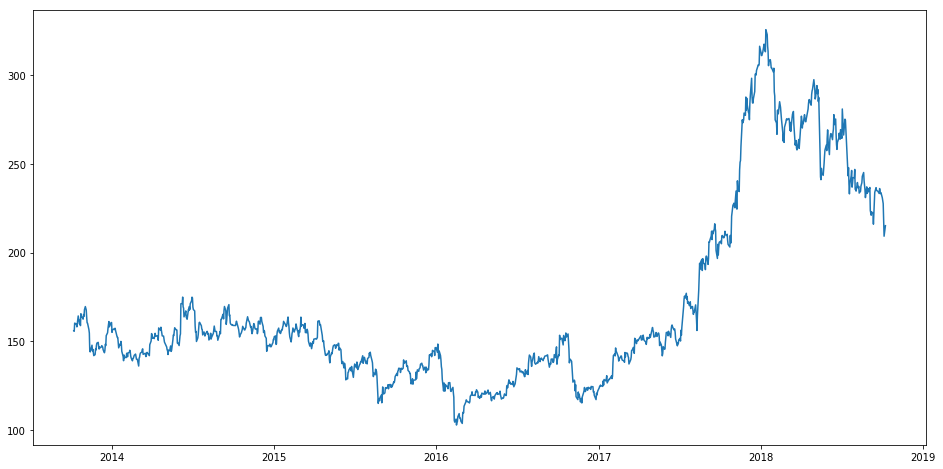

In [2]:
#converting the "Date" head to the Year, Month, Day format.
df["Date"] = pd.to_datetime(df.Date, format = "%Y-%m-%d")
df.index = df["Date"]

plt.figure(figsize = (16, 8))
#ploting the Closing Prices for each day.
plt.plot(df["Close"], label = "Close Price History.")


In [3]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

#Creating 'new_data' for the sorted 'Date' and 'Close' datas.
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index and droping the Date head as only Price is needed to be predicted now which has been sorted already.
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

#splitting train and test sets
train = dataset[0:987,:]
validation = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

#Converting into numpy array for plotting 
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

#Creating and fitting the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=2, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

#Creating the test data.
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

W0704 11:04:58.947967 139706710439808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0704 11:04:58.987827 139706710439808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0704 11:04:58.996397 139706710439808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0704 11:04:59.449616 139706710439808 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0704 11:04:59.749535 139706710439808 deprecation.py:323

Epoch 1/2
 - 191s - loss: 0.0013
Epoch 2/2
 - 187s - loss: 5.6463e-04


In [4]:
#The lower the rms value, the better the prediction will be.
rms = np.sqrt(np.mean(np.power((valid - closing_price), 2)))

print(rms)

8.03368786585169


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


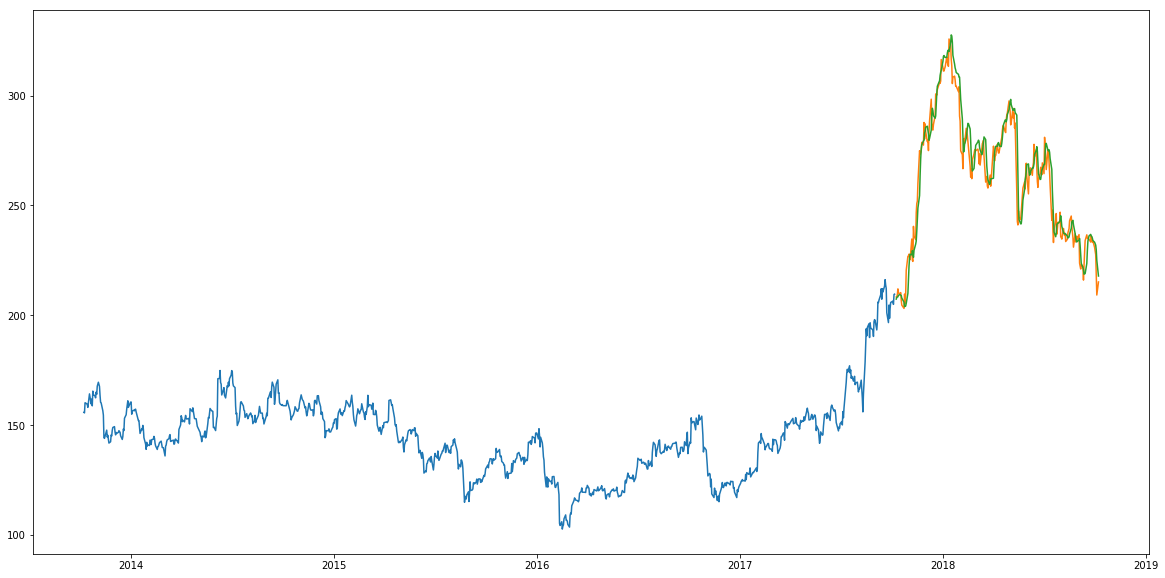

In [5]:
train = new_data[:987]
valid = new_data[987:]
valid["Predictions"] = closing_price

plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])



In [0]:
"""Orange colored graph represents for the data for the last 60 days
Green colored graph represents fot the predicted data which is in close approximation to the data of the last 60 days.
"""